<a href="https://colab.research.google.com/github/EMAT31530/ai-group-project-music-classification/blob/master/TSP%20Ordering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of an approximate solver for Metric Travelling Salesperson Problem
Steps:


1.   Take a collection of songs as input, 
2.   Convert audio data into spectrogram images 
3. Classify their genres using our CNN model
4. Take each song's softmax output to obtain the calculated probability of each genre
5. Interpret each soft-max output as position vectors in a multi-dimensional vector space, from 0-1 in each genre.
6. Order the track listing in such a way to  approximate a minimal S(X), the sum of each distance (some chosen distance/cost function d(x,y)) between consecutive songs in the vector space.
7.Output a track listing which gives our attempt at ordering songs into the most natural progression between genres




Want to solve the problem of finding the shortest route through a low (< 15) number of points in a multi-dimensional space. 
We attempt this using a Branch & Bound search algorithm, and implementing a genetic algorithm with mlrose:

https://arxiv.org/pdf/1805.04131.pdf

https://coral.ise.lehigh.edu/wiki/doku.php/travelling_salesman_problem

https://en.wikipedia.org/wiki/Genetic_algorithm

https://towardsdatascience.com/solving-travelling-salesperson-problems-with-python-5de7e883d847

In [2]:
import numpy as np
from numpy.random import seed
from numpy.random import rand
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd

In [8]:

df = pd.read_csv('/content/drive/MyDrive/playlist/softmax.csv')
df

,Unnamed: 0,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,Corpse Pose,0.0012,0.0674,0.0000,0.1739,0.0001,0.0000,0.0059,0.0884,0.0001,0.6629
1,All Along the Watchtower,0.0731,0.0016,0.2933,0.0336,0.0001,0.0735,0.0005,0.0303,0.0007,0.4934
2,LEAVING HELL,0.0000,0.0000,0.2864,0.4507,0.0000,0.0000,0.0000,0.0001,0.2555,0.0073
3,Love and or Hate Trigger,0.0000,0.0000,0.0000,0.3853,0.3142,0.0000,0.0006,0.2884,0.0115,0.0000
4,Dsco,0.0000,0.0060,0.0016,0.0524,0.0000,0.0001,0.0005,0.0344,0.0000,0.9050
5,Diary of a Rose,0.0001,0.0000,0.5247,0.2062,0.0000,0.0000,0.0000,0.0047,0.1696,0.0948
6,Abusey Junction,0.0012,0.0000,0.0324,0.0000,0.0000,0.0000,0.0000,0.0000,0.9664,0.0000
7,Circuits,0.0000,0.9287,0.0001,0.0004,0.0000,0.0001,0.0000,0.0359,0.0002,0.0346
8,Like a Buoy,0.0024,0.3121,0.0032,0.0123,0.0000,0.0083,0.0000,0.0072,0.0002,0.6541
9,George Street,0.0000,0.1662,0.0000,0.0009,0.0000,0.0000,0.0006,0.0803,0.0224,0.7295


In [ ]:
x.shape

(29,)

In [11]:
df.iloc[:,1:]

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,0.0012,0.0674,0.0000,0.1739,0.0001,0.0000,0.0059,0.0884,0.0001,0.6629
1,0.0731,0.0016,0.2933,0.0336,0.0001,0.0735,0.0005,0.0303,0.0007,0.4934
2,0.0000,0.0000,0.2864,0.4507,0.0000,0.0000,0.0000,0.0001,0.2555,0.0073
3,0.0000,0.0000,0.0000,0.3853,0.3142,0.0000,0.0006,0.2884,0.0115,0.0000
4,0.0000,0.0060,0.0016,0.0524,0.0000,0.0001,0.0005,0.0344,0.0000,0.9050
5,0.0001,0.0000,0.5247,0.2062,0.0000,0.0000,0.0000,0.0047,0.1696,0.0948
6,0.0012,0.0000,0.0324,0.0000,0.0000,0.0000,0.0000,0.0000,0.9664,0.0000
7,0.0000,0.9287,0.0001,0.0004,0.0000,0.0001,0.0000,0.0359,0.0002,0.0346
8,0.0024,0.3121,0.0032,0.0123,0.0000,0.0083,0.0000,0.0072,0.0002,0.6541
9,0.0000,0.1662,0.0000,0.0009,0.0000,0.0000,0.0006,0.0803,0.0224,0.7295


In [24]:
values = df.iloc[:,1:]
values = values.to_numpy()

In [25]:
values = values[:10,:]

In [26]:
#Size of Array + Dimensions
num_songs, num_dim = values.shape
seed(3)

In [ ]:

#for i in range(0,L-1):
 # genre_index[i]=L
random_int = np.random.randint(1, 100, num_songs) * 0.2

values = np.zeros((num_songs,num_genres)) 
for i in range(num_songs):
  alpha = np.divide(np.ones(num_genres),random_int[i])
  values[i,:] = np.random.dirichlet(alpha,size=1)
#rand_gen = rand(num_genres,num_songs)
#rand_sum = np.sum(rand_gen, axis = 1)
#values = rand_generator
print(values)



In [ ]:
#################### Random Generation for Testing #######################

In [ ]:
values3D = np.zeros((num_songs,3)) 
for i in range(num_songs):
  alpha = np.divide(np.ones(3),random_int[i])
  values3D[i,:] = np.random.dirichlet(alpha,size=1)
values3D

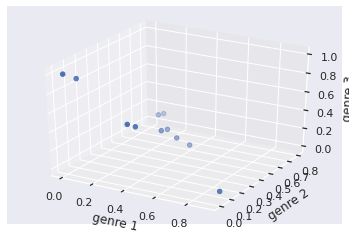

In [ ]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(values3D[:,0], values3D[:,1], values3D[:,2])
# Method 1
ax.set_xlabel('genre 1')
ax.set_ylabel('genre 2')
ax.set_zlabel('genre 3')
#plt.title('collection softmax outputs as 3-genre vector space')
#plt.show()
plt.savefig('/content/drive/MyDrive/3Dgenreplot')

In [27]:
def distance_matrix(values):
  dist_matrix = np.zeros((num_songs,num_songs))
  for i in range(num_songs):
    for j in range(num_songs):
      dist_matrix[i,j]= distance.euclidean(values[i,:],values[j,:])

  dist_matrix = dist_matrix.round(4)   
  
  return dist_matrix                                         


In [28]:
dist_matrix = distance_matrix(values)

In [29]:
# Python3 program to solve 
# Traveling Salesman Problem using 
# Branch and Bound.
import math
maxsize = float('inf')
  
# Function to copy temporary solution
# to the final solution
def copyToFinal(curr_path):
    final_path[:N + 1] = curr_path[:]
    final_path[N] = curr_path[0]
  
# Function to find the minimum edge cost 
# having an end at the vertex i
def firstMin(adj, i):
    min = maxsize
    for k in range(N):
        if adj[i][k] < min and i != k:
            min = adj[i][k]
  
    return min
  
# function to find the second minimum edge 
# cost having an end at the vertex i
def secondMin(adj, i):
    first, second = maxsize, maxsize
    for j in range(N):
        if i == j:
            continue
        if adj[i][j] <= first:
            second = first
            first = adj[i][j]
  
        elif(adj[i][j] <= second and 
             adj[i][j] != first):
            second = adj[i][j]
  
    return second
  
# function that takes as arguments:
# curr_bound -> lower bound of the root node
# curr_weight-> stores the weight of the path so far
# level-> current level while moving
# in the search space tree
# curr_path[] -> where the solution is being stored
# which would later be copied to final_path[]
def TSPRec(adj, curr_bound, curr_weight, 
              level, curr_path, visited):
    global final_res
      
    # base case is when we have reached level N 
    # which means we have covered all the nodes once
    if level == N:
          
        # check if there is an edge from
        # last vertex in path back to the first vertex
        if adj[curr_path[level - 1]][curr_path[0]] != 0:
              
            # curr_res has the total weight
            # of the solution we got
            curr_res = curr_weight + adj[curr_path[level - 1]]\
                                        [curr_path[0]]
            if curr_res < final_res:
                copyToFinal(curr_path)
                final_res = curr_res
        return
  
    # for any other level iterate for all vertices
    # to build the search space tree recursively
    for i in range(N):
          
        # Consider next vertex if it is not same 
        # (diagonal entry in adjacency matrix and 
        #  not visited already)
        if (adj[curr_path[level-1]][i] != 0 and
                            visited[i] == False):
            temp = curr_bound
            curr_weight += adj[curr_path[level - 1]][i]
  
            # different computation of curr_bound 
            # for level 2 from the other levels
            if level == 1:
                curr_bound -= ((firstMin(adj, curr_path[level - 1]) + 
                                firstMin(adj, i)) / 2)
            else:
                curr_bound -= ((secondMin(adj, curr_path[level - 1]) +
                                 firstMin(adj, i)) / 2)
  
            # curr_bound + curr_weight is the actual lower bound 
            # for the node that we have arrived on.
            # If current lower bound < final_res, 
            # we need to explore the node further
            if curr_bound + curr_weight < final_res:
                curr_path[level] = i
                visited[i] = True
                  
                # call TSPRec for the next level
                TSPRec(adj, curr_bound, curr_weight, 
                       level + 1, curr_path, visited)
  
            # Else we have to prune the node by resetting 
            # all changes to curr_weight and curr_bound
            curr_weight -= adj[curr_path[level - 1]][i]
            curr_bound = temp
  
            # Also reset the visited array
            visited = [False] * len(visited)
            for j in range(level):
                if curr_path[j] != -1:
                    visited[curr_path[j]] = True
  
# This function sets up final_path
def TSP(adj):
      
    # Calculate initial lower bound for the root node 
    # using the formula 1/2 * (sum of first min + 
    # second min) for all edges. Also initialize the 
    # curr_path and visited array
    curr_bound = 0
    curr_path = [-1] * (N + 1)
    visited = [False] * N
  
    # Compute initial bound
    for i in range(N):
        curr_bound += (firstMin(adj, i) + 
                       secondMin(adj, i))
  
    # Rounding off the lower bound to an integer
    curr_bound = math.ceil(curr_bound / 2)
  
    # We start at vertex 1 so the first vertex 
    # in curr_path[] is 0
    visited[0] = True
    curr_path[0] = 0
  
    # Call to TSPRec for curr_weight 
    # equal to 0 and level 1
    TSPRec(adj, curr_bound, 0, 1, curr_path, visited)
  
# Driver code
  
# Adjacency matrix for the given graph
N = num_songs
adj = dist_matrix
  
# final_path[] stores the final solution 
# i.e. the // path of the salesman.
final_path = [None] * (N + 1)
  
# visited[] keeps track of the already
# visited nodes in a particular path
visited = [False] * N
  
# Stores the final minimum weight
# of shortest tour.
final_res = maxsize
  
TSP(adj)
  
print("Minimum cost :", final_res)
print("Path Taken : ", end = ' ')
for i in range(N + 1):
    print(final_path[i], end = ' ')

Minimum cost : 5.9017
Path Taken :  0 1 5 2 3 6 7 8 9 4 0 

Next, we need to add a dummy node with zeroed distances to act as start and end node, avoiding the cycle being taken into account

In [30]:
#Want to add a dummy node to represent the 1st and last destinations of TSP problem
#we define the dummy's distance value to be half the minimum non-zero value in distance matrix from every distance
def dummy_var(dist_matrix):

  minval = np.min(dist_matrix[np.nonzero(dist_matrix)])
  dum_value = minval/2
  dist_matrix_dum = np.pad(dist_matrix,((1,0),), 'constant',constant_values=(dum_value))
  return dist_matrix_dum , dum_value

In [31]:
dist_matrix_dum , dum_value = dummy_var(dist_matrix)

In [32]:
# Adjacency matrix for the given graph
N = num_songs+1
adj = dist_matrix_dum
  
# final_path[] stores the final solution 
# i.e. the // path of the salesman.
final_path = [None] * (N + 1)
  
# visited[] keeps track of the already
# visited nodes in a particular path
visited = [False] * N
  
# Stores the final minimum weight
# of shortest tour.
final_res = maxsize
  
TSP(adj)
# Since we have defined the dummy variable to be half the minimum non-zero value in distance matrix
# subtract 2*dummy value from minumum cost to get actual distance cost of a path without a final return making it a tour
branch_cost = final_res - dum_value*2
print("Minimum cost :", branch_cost)
print("Path Taken : ", end = ' ')
#best_state_branch = np.zeros(N)
#for i in range(N + 1):
    #final_path[i], end = ' '
best_state_branch = final_path
print(best_state_branch)



Minimum cost : 4.9613999999999985
Path Taken :  [0, 2, 1, 5, 10, 9, 8, 4, 3, 6, 7, 0]


As we can see, the dummy variable removes the final distance completing the tour from being taken into count into the optimization, since its distance is the smallest



### Genetic Algorithm Method
Implementation using Mlrose

In [33]:
pip install mlrose

In [ ]:
import mlrose

In [34]:


#First we attempt a tour, rather than a path (starts and ends at same node)

dist_list=[]
count=1
for i in range(num_songs):
  for j in range(num_songs):
    if i!=j:
      dist_list.append((i,j,dist_matrix[i,j]))
      count+=1
print(dist_list)

[(0, 1, 0.3908), (0, 2, 0.8161), (0, 3, 0.7921), (0, 4, 0.283), (0, 5, 0.7996), (0, 6, 1.1903), (0, 7, 1.0814), (0, 8, 0.3046), (0, 9, 0.2115), (1, 0, 0.3908), (1, 2, 0.6978), (1, 3, 0.7933), (1, 4, 0.5154), (1, 5, 0.5312), (1, 6, 1.121), (1, 7, 1.0807), (1, 8, 0.4654), (1, 9, 0.4285), (2, 0, 0.8161), (2, 1, 0.6978), (2, 3, 0.5725), (2, 4, 1.0546), (2, 5, 0.3628), (2, 6, 0.8792), (2, 7, 1.102), (2, 8, 0.9238), (2, 9, 0.9457), (3, 0, 0.7921), (3, 1, 0.7933), (3, 2, 0.5725), (3, 4, 1.0456), (3, 5, 0.7215), (3, 6, 1.115), (3, 7, 1.0837), (3, 8, 0.9178), (3, 9, 0.9218), (4, 0, 0.283), (4, 1, 0.5154), (4, 2, 1.0546), (4, 3, 1.0456), (4, 5, 0.9917), (4, 6, 1.3258), (4, 7, 1.2695), (4, 8, 0.3988), (4, 9, 0.2485), (5, 0, 0.7996), (5, 1, 0.5312), (5, 2, 0.3628), (5, 3, 0.7215), (5, 4, 0.9917), (5, 6, 0.9637), (5, 7, 1.1015), (5, 8, 0.8652), (5, 9, 0.8805), (6, 0, 1.1903), (6, 1, 1.121), (6, 2, 0.8792), (6, 3, 1.115), (6, 4, 1.3258), (6, 5, 0.9637), (6, 7, 1.3415), (6, 8, 1.2083), (6, 9, 1.2077)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [35]:
# Initialize fitness function object using dist_list
fitness_dists = mlrose.TravellingSales(distances = dist_list)
problem_fit = mlrose.TSPOpt(length = num_songs, fitness_fn = fitness_dists, maximize=False)
#problem_fit = mlrose.TSPOpt(length = num_songs, distances = dist_list, maximize=False)
# Solve problem using the genetic algorithm
best_state, best_fitness = mlrose.genetic_alg(problem_fit, random_state = 2)

print('The best state found is: ', best_state)

print('The fitness at the best state is: ', best_fitness)



The best state found is:  [2 3 1 4 0 8 9 7 6 5]
The fitness at the best state is:  6.3513


In [36]:
#Tune parameters to attempt to find better estimate
best_state, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, 
					      max_attempts = 100, random_state = 2)

print('The best state found is: ', best_state)

print('The fitness at the best state is: ', best_fitness)

The best state found is:  [3 6 2 5 1 9 4 0 8 7]
The fitness at the best state is:  6.1112


In [45]:
#Now we add a dummy node of negligible distance from each node to calculate path (no cycle)
#So as a tour is calculated, the final 
def genetic_path(dist_matrix_dum):
  dist_list=[]
  count=1
  dummy_node = num_songs+1
  for i in range(dummy_node):
    for j in range(dummy_node):
      if i!=j:
        dist_list.append((i,j,dist_matrix_dum[i,j]))
        count+=1
  #print(dist_list)


  fitness_dists = mlrose.TravellingSales(distances = dist_list)
  problem_fit = mlrose.TSPOpt(length = dummy_node, fitness_fn = fitness_dists, maximize=False)
  best_state_genetic, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, 
					      max_attempts = 100)# random_state = 2)

  print('The best state found is: ', best_state_genetic)
  genetic_cost = best_fitness -2*dum_value
  print('The fitness (or total distance) at the best state is: ', genetic_cost)
  return best_state_genetic , genetic_cost


In [78]:
best_state_genetic, genetic_cost = genetic_path(dist_matrix_dum)

The best state found is:  [ 4  1 10  9  5  2  6  3  7  0  8]
The fitness (or total distance) at the best state is:  4.9564


In [79]:
np.min([genetic_cost,branch_cost])

4.9564

In [ ]:
 5,  9,  7,  1, 10,  0,  6,  4,  3,  8, 11,  2

# ----------------------Reorder Entries into Reduced Similarity Path ----------

In [80]:
reorder = [x for x in best_state_genetic if x != 0]
reorder = [x -1 for x in reorder]


In [81]:
reorder

[3, 0, 9, 8, 4, 1, 5, 2, 6, 7]

In [89]:
reorder_index = np.zeros(10,dtype = int)
for i in range(len(reorder)):
  reorder_index[reorder[i]] = i 


In [90]:
reorder_index

array([1, 5, 7, 0, 4, 6, 8, 9, 3, 2])

In [91]:
df_subset = df.iloc[:10,:]

In [92]:
df_subset.assign(reorder = pd.Series(reorder_index).values)

,Unnamed: 0,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,reorder
0,Corpse Pose,0.0012,0.0674,0.0000,0.1739,0.0001,0.0000,0.0059,0.0884,0.0001,0.6629,1
1,All Along the Watchtower,0.0731,0.0016,0.2933,0.0336,0.0001,0.0735,0.0005,0.0303,0.0007,0.4934,5
2,LEAVING HELL,0.0000,0.0000,0.2864,0.4507,0.0000,0.0000,0.0000,0.0001,0.2555,0.0073,7
3,Love and or Hate Trigger,0.0000,0.0000,0.0000,0.3853,0.3142,0.0000,0.0006,0.2884,0.0115,0.0000,0
4,Dsco,0.0000,0.0060,0.0016,0.0524,0.0000,0.0001,0.0005,0.0344,0.0000,0.9050,4
5,Diary of a Rose,0.0001,0.0000,0.5247,0.2062,0.0000,0.0000,0.0000,0.0047,0.1696,0.0948,6
6,Abusey Junction,0.0012,0.0000,0.0324,0.0000,0.0000,0.0000,0.0000,0.0000,0.9664,0.0000,8
7,Circuits,0.0000,0.9287,0.0001,0.0004,0.0000,0.0001,0.0000,0.0359,0.0002,0.0346,9
8,Like a Buoy,0.0024,0.3121,0.0032,0.0123,0.0000,0.0083,0.0000,0.0072,0.0002,0.6541,3
9,George Street,0.0000,0.1662,0.0000,0.0009,0.0000,0.0000,0.0006,0.0803,0.0224,0.7295,2


In [96]:
df_subset = df_subset.reindex(reorder)

In [97]:
df_subset

,Unnamed: 0,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
3,Love and or Hate Trigger,0.0000,0.0000,0.0000,0.3853,0.3142,0.0000,0.0006,0.2884,0.0115,0.0000
0,Corpse Pose,0.0012,0.0674,0.0000,0.1739,0.0001,0.0000,0.0059,0.0884,0.0001,0.6629
9,George Street,0.0000,0.1662,0.0000,0.0009,0.0000,0.0000,0.0006,0.0803,0.0224,0.7295
8,Like a Buoy,0.0024,0.3121,0.0032,0.0123,0.0000,0.0083,0.0000,0.0072,0.0002,0.6541
4,Dsco,0.0000,0.0060,0.0016,0.0524,0.0000,0.0001,0.0005,0.0344,0.0000,0.9050
1,All Along the Watchtower,0.0731,0.0016,0.2933,0.0336,0.0001,0.0735,0.0005,0.0303,0.0007,0.4934
5,Diary of a Rose,0.0001,0.0000,0.5247,0.2062,0.0000,0.0000,0.0000,0.0047,0.1696,0.0948
2,LEAVING HELL,0.0000,0.0000,0.2864,0.4507,0.0000,0.0000,0.0000,0.0001,0.2555,0.0073
6,Abusey Junction,0.0012,0.0000,0.0324,0.0000,0.0000,0.0000,0.0000,0.0000,0.9664,0.0000
7,Circuits,0.0000,0.9287,0.0001,0.0004,0.0000,0.0001,0.0000,0.0359,0.0002,0.0346


In [98]:
df_subset.to_csv('/content/drive/MyDrive/playlist/reordered_playlist.csv')



# ------------------ Dimensionality Reduction -----------------------------

In [ ]:
import sklearn.datasets
import sklearn.manifold
import sklearn.decomposition

In [ ]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# ---------------- t-SNE -------------------------

In [ ]:
X, y = load_digits(return_X_y=True)
tsne = TSNE(n_components = 2)
tsne_data = tsne.fit_transform(values)

In [ ]:
tsne_data

array([[-18.288874  ,  -2.9571552 ],
       [ -2.260874  ,  -3.0843496 ],
       [-39.07948   , -13.205847  ],
       [ 32.52068   ,  -6.707279  ],
       [-10.184676  ,  -4.5935183 ],
       [-15.917079  ,   6.84536   ],
       [-32.44519   ,  12.36897   ],
       [  1.2158442 , -36.658424  ],
       [ 26.591589  , -17.405865  ],
       [ -0.8704273 ,   7.849647  ],
       [ -4.100748  , -11.383193  ],
       [-38.482967  ,  21.301756  ],
       [  8.059363  , -20.11033   ],
       [-14.783102  , -14.373084  ],
       [ 32.24351   ,  15.459547  ],
       [ 15.683019  , -30.38335   ],
       [-28.755505  ,  -8.86886   ],
       [-10.508346  ,  13.946213  ],
       [ -1.3800849 ,  28.08974   ],
       [-19.28869   ,  15.392712  ],
       [-27.05812   , -33.865925  ],
       [ -3.2333512 ,  17.777416  ],
       [ 12.518897  ,  39.403942  ],
       [  6.4024673 ,  13.987137  ],
       [-13.095605  ,  43.55126   ],
       [-22.689413  ,  22.897272  ],
       [  4.978737  ,  -8.96732   ],
 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


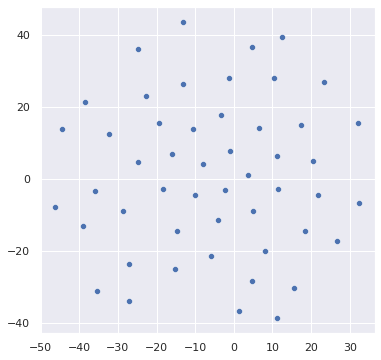

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig = plt.figure(figsize=(6,6))
palette = sns.color_palette("bright", 8)
sns.scatterplot(tsne_data[:,0], tsne_data[:,1], legend='full')#, palette=palette)
plt.savefig('t-snes_2d', bbox_inches='tight')

In [ ]:
dist_matrix_tsne = distance_matrix(tsne_data)
dist_matrix_dum_tsne, dum_value = dummy_var(dist_matrix_tsne)
genetic_path(dist_matrix_dum_tsne)

The best state found is:  [ 0  2  5  1  9  6  8  7 10  4  3 11]
The fitness (or total distance) at the best state is:  1761.9525000000003


(array([ 0,  2,  5,  1,  9,  6,  8,  7, 10,  4,  3, 11]), 1761.9525000000003)

# -------------------Principal Component Analysis -----------------------

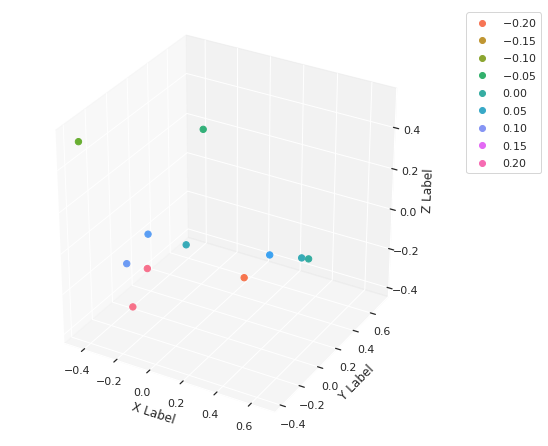

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

X, y = load_digits(return_X_y=True)
pca = PCA(n_components = 4)
pca_data = pca.fit_transform(values)
pca_data

# axes instance
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(pca_data[:,0], pca_data[:,1],pca_data[:,2], s=40, c=pca_data[:,3], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [ ]:
plt.savefig('/content/drive/MyDrive/3Dgenreplot')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


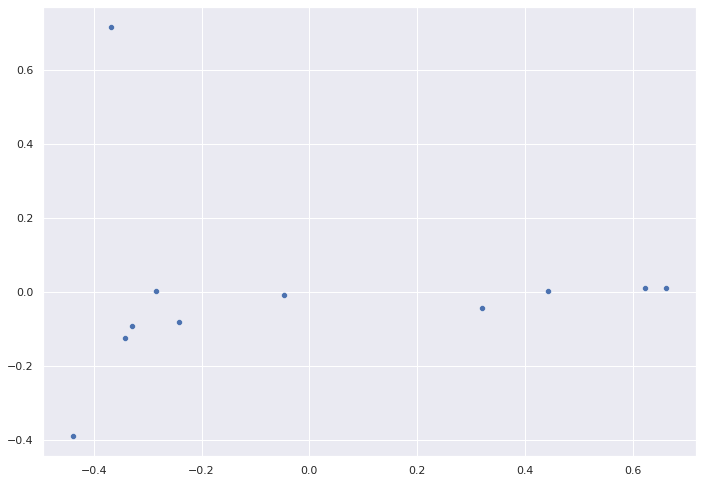

In [ ]:
X, y = load_digits(return_X_y=True)
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(values)
pca_data
sns.scatterplot(pca_data[:,0], pca_data[:,1], legend='full')#, palette=palette)

In [ ]:
plt.savefig('pca_2d', bbox_inches='tight')

<Figure size 842.4x595.44 with 0 Axes>

In [ ]:
dist_matrix = np.zeros((num_songs,num_songs))
for i in range(num_songs):
  for j in range(num_songs):
    dist_matrix[i,j]= distance.euclidean(pca_data[i,:],pca_data[j,:])

dist_matrix_pca = dist_matrix.round(4)   

In [ ]:
# Add Dummy Variable to PCA Distance Matrix and Run through genetic algorithm
dist_matrix_pca = distance_matrix(pca_data)
dist_matrix_pca
dist_matrix_dum_pca , dum_value = dummy_var(dist_matrix_pca)
genetic_path(dist_matrix_dum_pca)

The best state found is:  [ 5  9  7  1 10  0  6  4  3  8 11  2]
The fitness (or total distance) at the best state is:  3.0385


(array([ 5,  9,  7,  1, 10,  0,  6,  4,  3,  8, 11,  2]), 3.0385)